In [1]:
import settings
import settings_update
from helpers import misc_helpers

RUN_SIZE = 'full'

print('loading train/test data')
settings.RUN_SIZE = RUN_SIZE
settings_update.update_run_size_setup()
X_train, y_train, X_val, y_val, X_test, y_test, X, y, scaler_y = misc_helpers.get_data(
    filepath=settings.DATA_FILEPATH,
    train_years=settings.TRAIN_YEARS,
    val_years=settings.VAL_YEARS,
    test_years=settings.TEST_YEARS,
    n_points_per_group=settings.N_POINTS_PER_GROUP,
    do_standardize_data=True,
)

y_train, y_val, y_test, y = map(scaler_y.inverse_transform, [y_train, y_val, y_test, y])
y_train, y_val, y_test, y = misc_helpers.make_arrs_1d(y_train, y_val, y_test, y)
print('done')

loading train/test data


C:\Users\Mischa\Desktop\Uni\Master\MA\code\my_code\helpers\misc_helpers.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arr.drop(columns=ts_cols, inplace=True)  # todo: works bc no ts cols present?
C:\Users\Mischa\Desktop\Uni\Master\MA\code\my_code\helpers\misc_helpers.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arr.drop(columns=ts_cols, inplace=True)  # todo: works bc no ts cols present?
C:\Users\Mischa\Desktop\Uni\Master\MA\code\my_code\helpers\misc_helpers.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

done


In [2]:
import numpy as np

from helpers.io_helper import IO_Helper
from helpers.arr_helpers import get_method_to_arrs_gen

ARRAYS_FOLDER = 'arrays'
MODELS_FOLDER = 'models'

METHODS_WHITELIST = set([
    'qhgbr',
    'qr',
    'gp',
    'mvnn',
    'cp_hgbr',
    'cp_linreg',
    'cp_nn',
    'la_nn',
])
UQ_METHOD_TO_ARR_NAMES_DICT = {
    'qhgbr': [
        'native_qhgbr_y_pred_n210432_it0.npy',
        'native_qhgbr_y_quantiles_n210432_it0.npy',
        'native_qhgbr_y_std_n210432_it0.npy',
    ],
    'qr': [
        'native_quantile_regression_nn_y_pred_n210432_it300_nh2_hs50.npy',
        'native_quantile_regression_nn_y_quantiles_n210432_it300_nh2_hs50.npy',
        'native_quantile_regression_nn_y_std_n210432_it300_nh2_hs50.npy',
    ],
    'gp': [
        'native_gpytorch_y_pred_n210432_it200_new.npy',
        'native_gpytorch_y_quantiles_n210432_it200_new.npy',
        'native_gpytorch_y_std_n210432_it200_new.npy',
    ],
    'mvnn': [
        'native_mvnn_y_pred_n210432_it100_nh2_hs50.npy',
        'native_mvnn_y_quantiles_n210432_it100_nh2_hs50.npy',
        'native_mvnn_y_std_n210432_it100_nh2_hs50.npy',
    ],
    'cp_hgbr': [
        'posthoc_conformal_prediction_base_model_hgbr_y_pred_n210432_it5.npy',
        'posthoc_conformal_prediction_base_model_hgbr_y_quantiles_n210432_it5.npy',
        'posthoc_conformal_prediction_base_model_hgbr_y_std_n210432_it5.npy',
    ],
    'cp_linreg': [
        'posthoc_conformal_prediction_base_model_linreg_y_pred_n210432_it5.npy',
        'posthoc_conformal_prediction_base_model_linreg_y_quantiles_n210432_it5.npy',
        'posthoc_conformal_prediction_base_model_linreg_y_std_n210432_it5.npy',
    ],
    'cp_nn': [
        'posthoc_conformal_prediction_base_model_nn_y_pred_n210432_it5_cp2.npy',
        'posthoc_conformal_prediction_base_model_nn_y_quantiles_n210432_it5_cp2.npy',
        'posthoc_conformal_prediction_base_model_nn_y_std_n210432_it5_cp2.npy',
    ],
    'la_nn': [
        'posthoc_laplace_approximation_base_model_nn_y_pred_n210432_it1000_la2.npy',
        'posthoc_laplace_approximation_base_model_nn_y_quantiles_n210432_it1000_la2.npy',
        'posthoc_laplace_approximation_base_model_nn_y_std_n210432_it1000_la2.npy',
    ],
}


print('loading predictions')
io_helper = IO_Helper(arrays_folder=ARRAYS_FOLDER, models_folder=MODELS_FOLDER)

n_test_samples = y_test.shape[0]

uq_method_to_arrs_gen = get_method_to_arrs_gen(
    methods_whitelist=METHODS_WHITELIST,
    method_to_arr_names_dict=UQ_METHOD_TO_ARR_NAMES_DICT,
    io_helper=io_helper,
)
uq_method_to_arrs_dict = dict(uq_method_to_arrs_gen)
print('done')

loading predictions
done


In [3]:
# compute calibrations

print('computing calibrations')

y_test_rep = np.vstack([y_test] * len(settings.QUANTILES))
y_test_rep = y_test_rep.transpose()

method_calibrations = {}
for method, arrs in uq_method_to_arrs_dict.items():
    y_pred, y_quantiles, y_std = arrs
    y_pred_test, y_quantiles_test, y_std_test = [arr[-n_test_samples:] for arr in arrs]

    calibration_arr = (y_test_rep <= y_quantiles_test)
    calibration_vals = calibration_arr.mean(axis=0)
    method_calibrations[method] = calibration_vals
print('done')

computing calibrations
done


In [4]:
print('mean abs miscalibration:')
quantiles = np.array(settings.QUANTILES)
for method, calibration_arr in method_calibrations.items():
    mean_abs_miscalibration = np.abs(calibration_arr - quantiles).mean()
    print(f'{method}: {mean_abs_miscalibration:.3}')

mean abs miscalibration:
qhgbr: 0.0393
qr: 0.0509
gp: 0.0627
mvnn: 0.136
cp_hgbr: 0.0319
cp_linreg: 0.0383
cp_nn: 0.0572
la_nn: 0.0546


plotting native
plotting posthoc
saving
showing


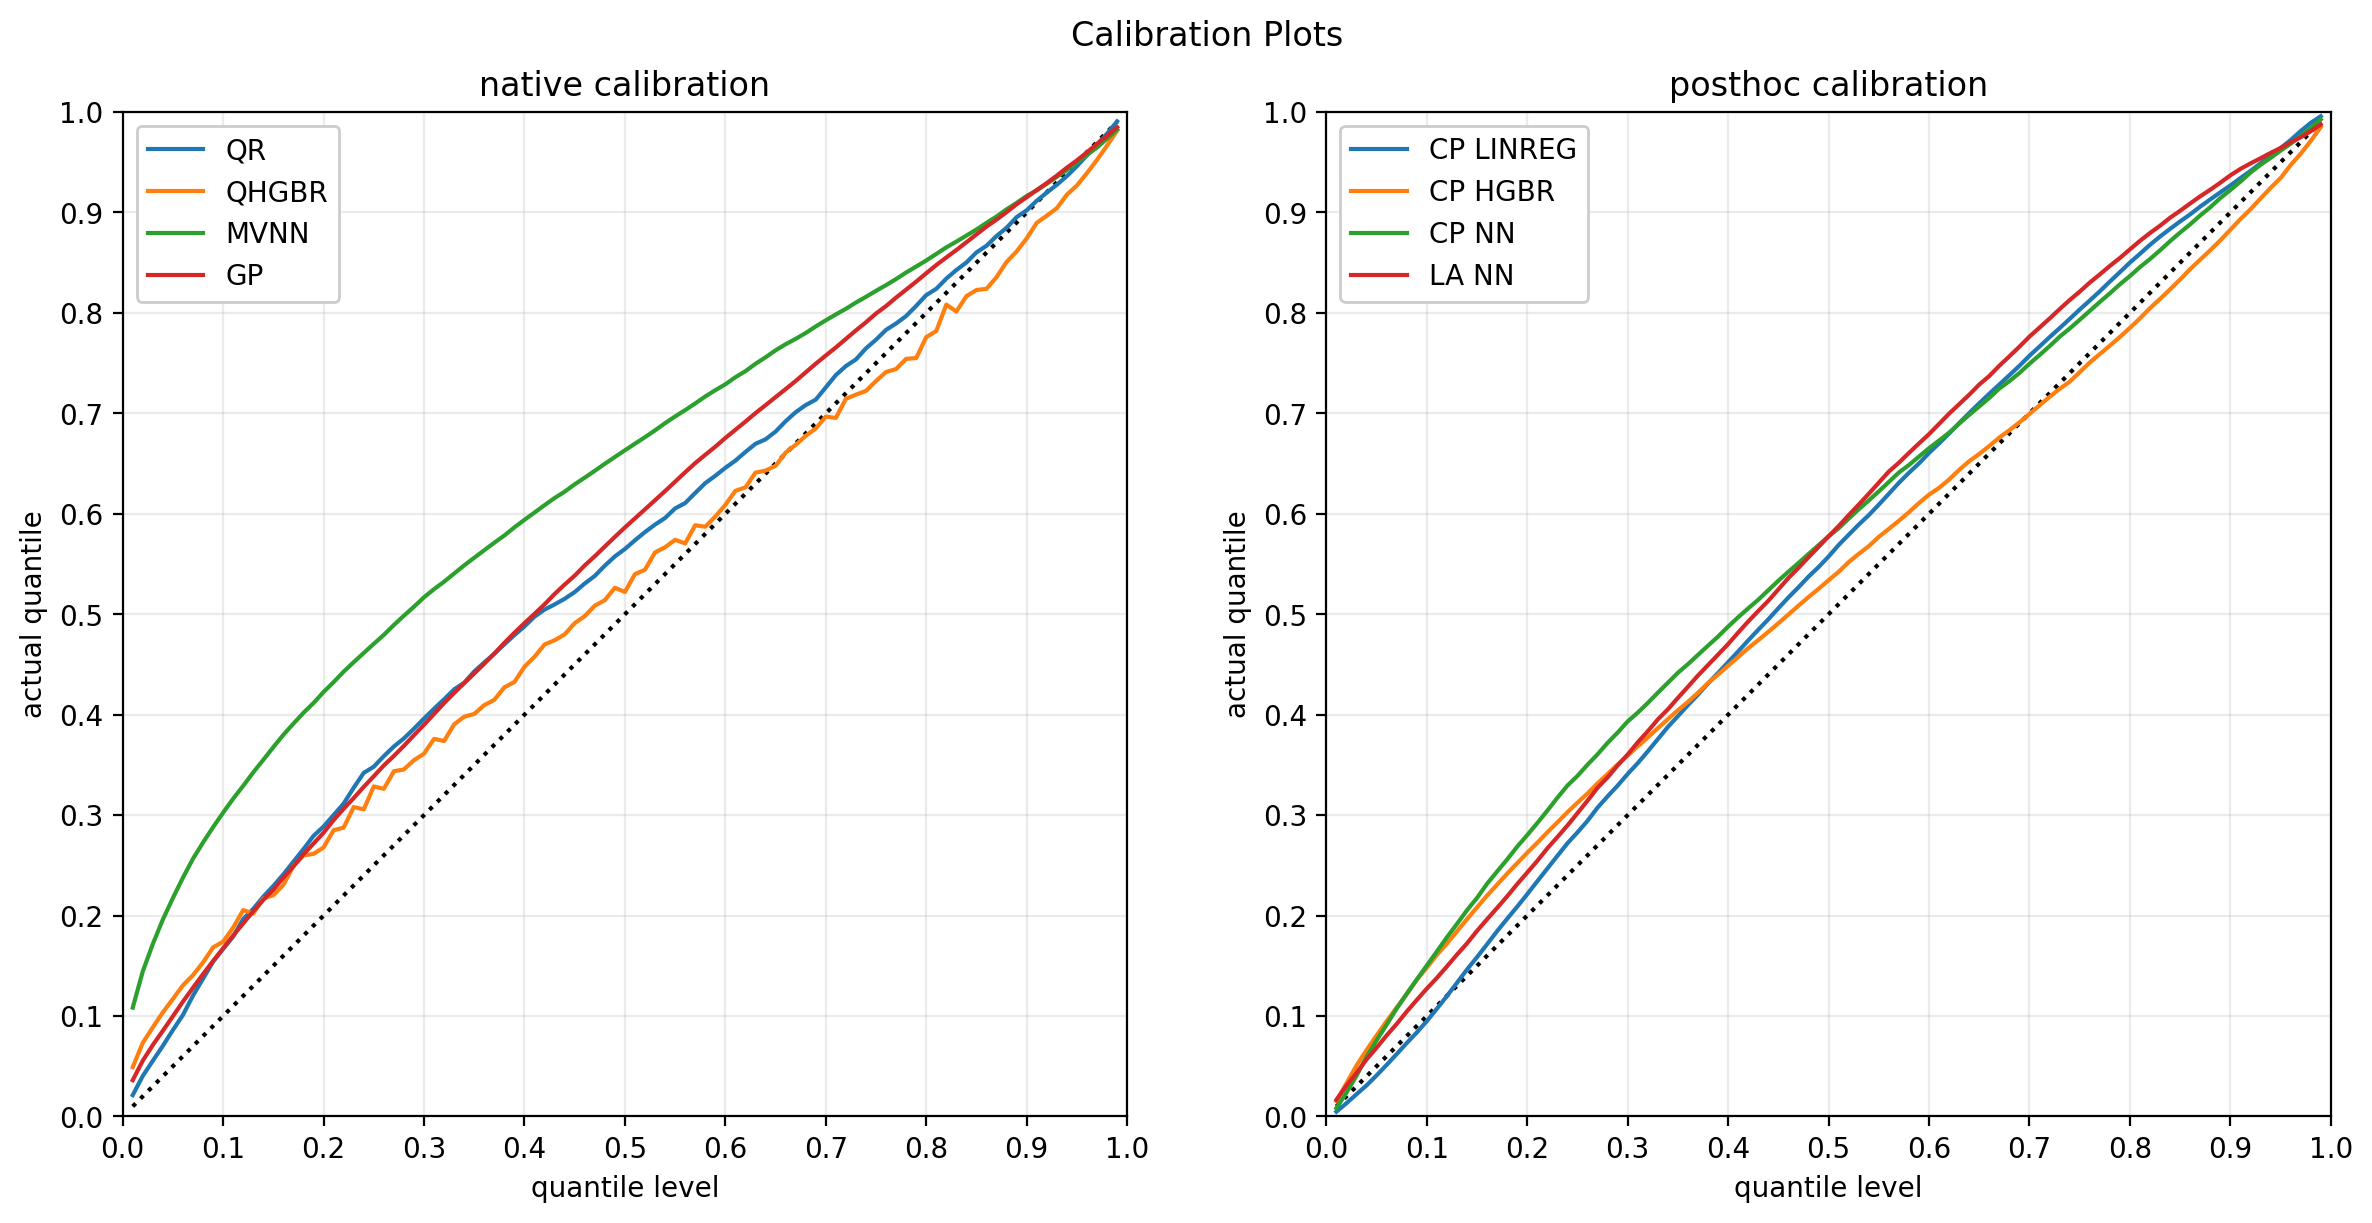

In [5]:
import matplotlib.pyplot as plt


def _clean_label(label):
    return ' '.join(label.split('_')).upper()


DPI = 200
FILEPATH = 'comparison_storage/plots/calibration_plot.pdf'


METHOD_TYPE_DICT = {
    'native': ['qr', 'qhgbr', 'mvnn', 'gp'],
    'posthoc': ['cp_linreg', 'cp_hgbr', 'cp_nn', 'la_nn']
}
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

ticks = np.linspace(0, 1, 11)
x_plot = settings.QUANTILES
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), layout='constrained', dpi=DPI)
fig.suptitle('Calibration Plots')
for ax, (method_type, methods) in zip(axs, METHOD_TYPE_DICT.items()):
    print(f'plotting {method_type}')
    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.plot(x_plot, x_plot, linestyle='dotted', color='black')
    ax.set_title(f'{method_type} calibration')
    ax.set_xlabel('quantile level')
    ax.set_ylabel('actual quantile')
    ax.grid(True, alpha=0.25)

    for method, color in zip(methods, COLORS):
        calibrations = method_calibrations[method]
        ax.plot(x_plot, calibrations, label=_clean_label(method))
    ax.legend(framealpha=1)

if FILEPATH is not None:
    print('saving')
    plt.savefig(FILEPATH)
print('showing')

plotting Baseline
plotting Tree
plotting NN
plotting GP
saving
showing


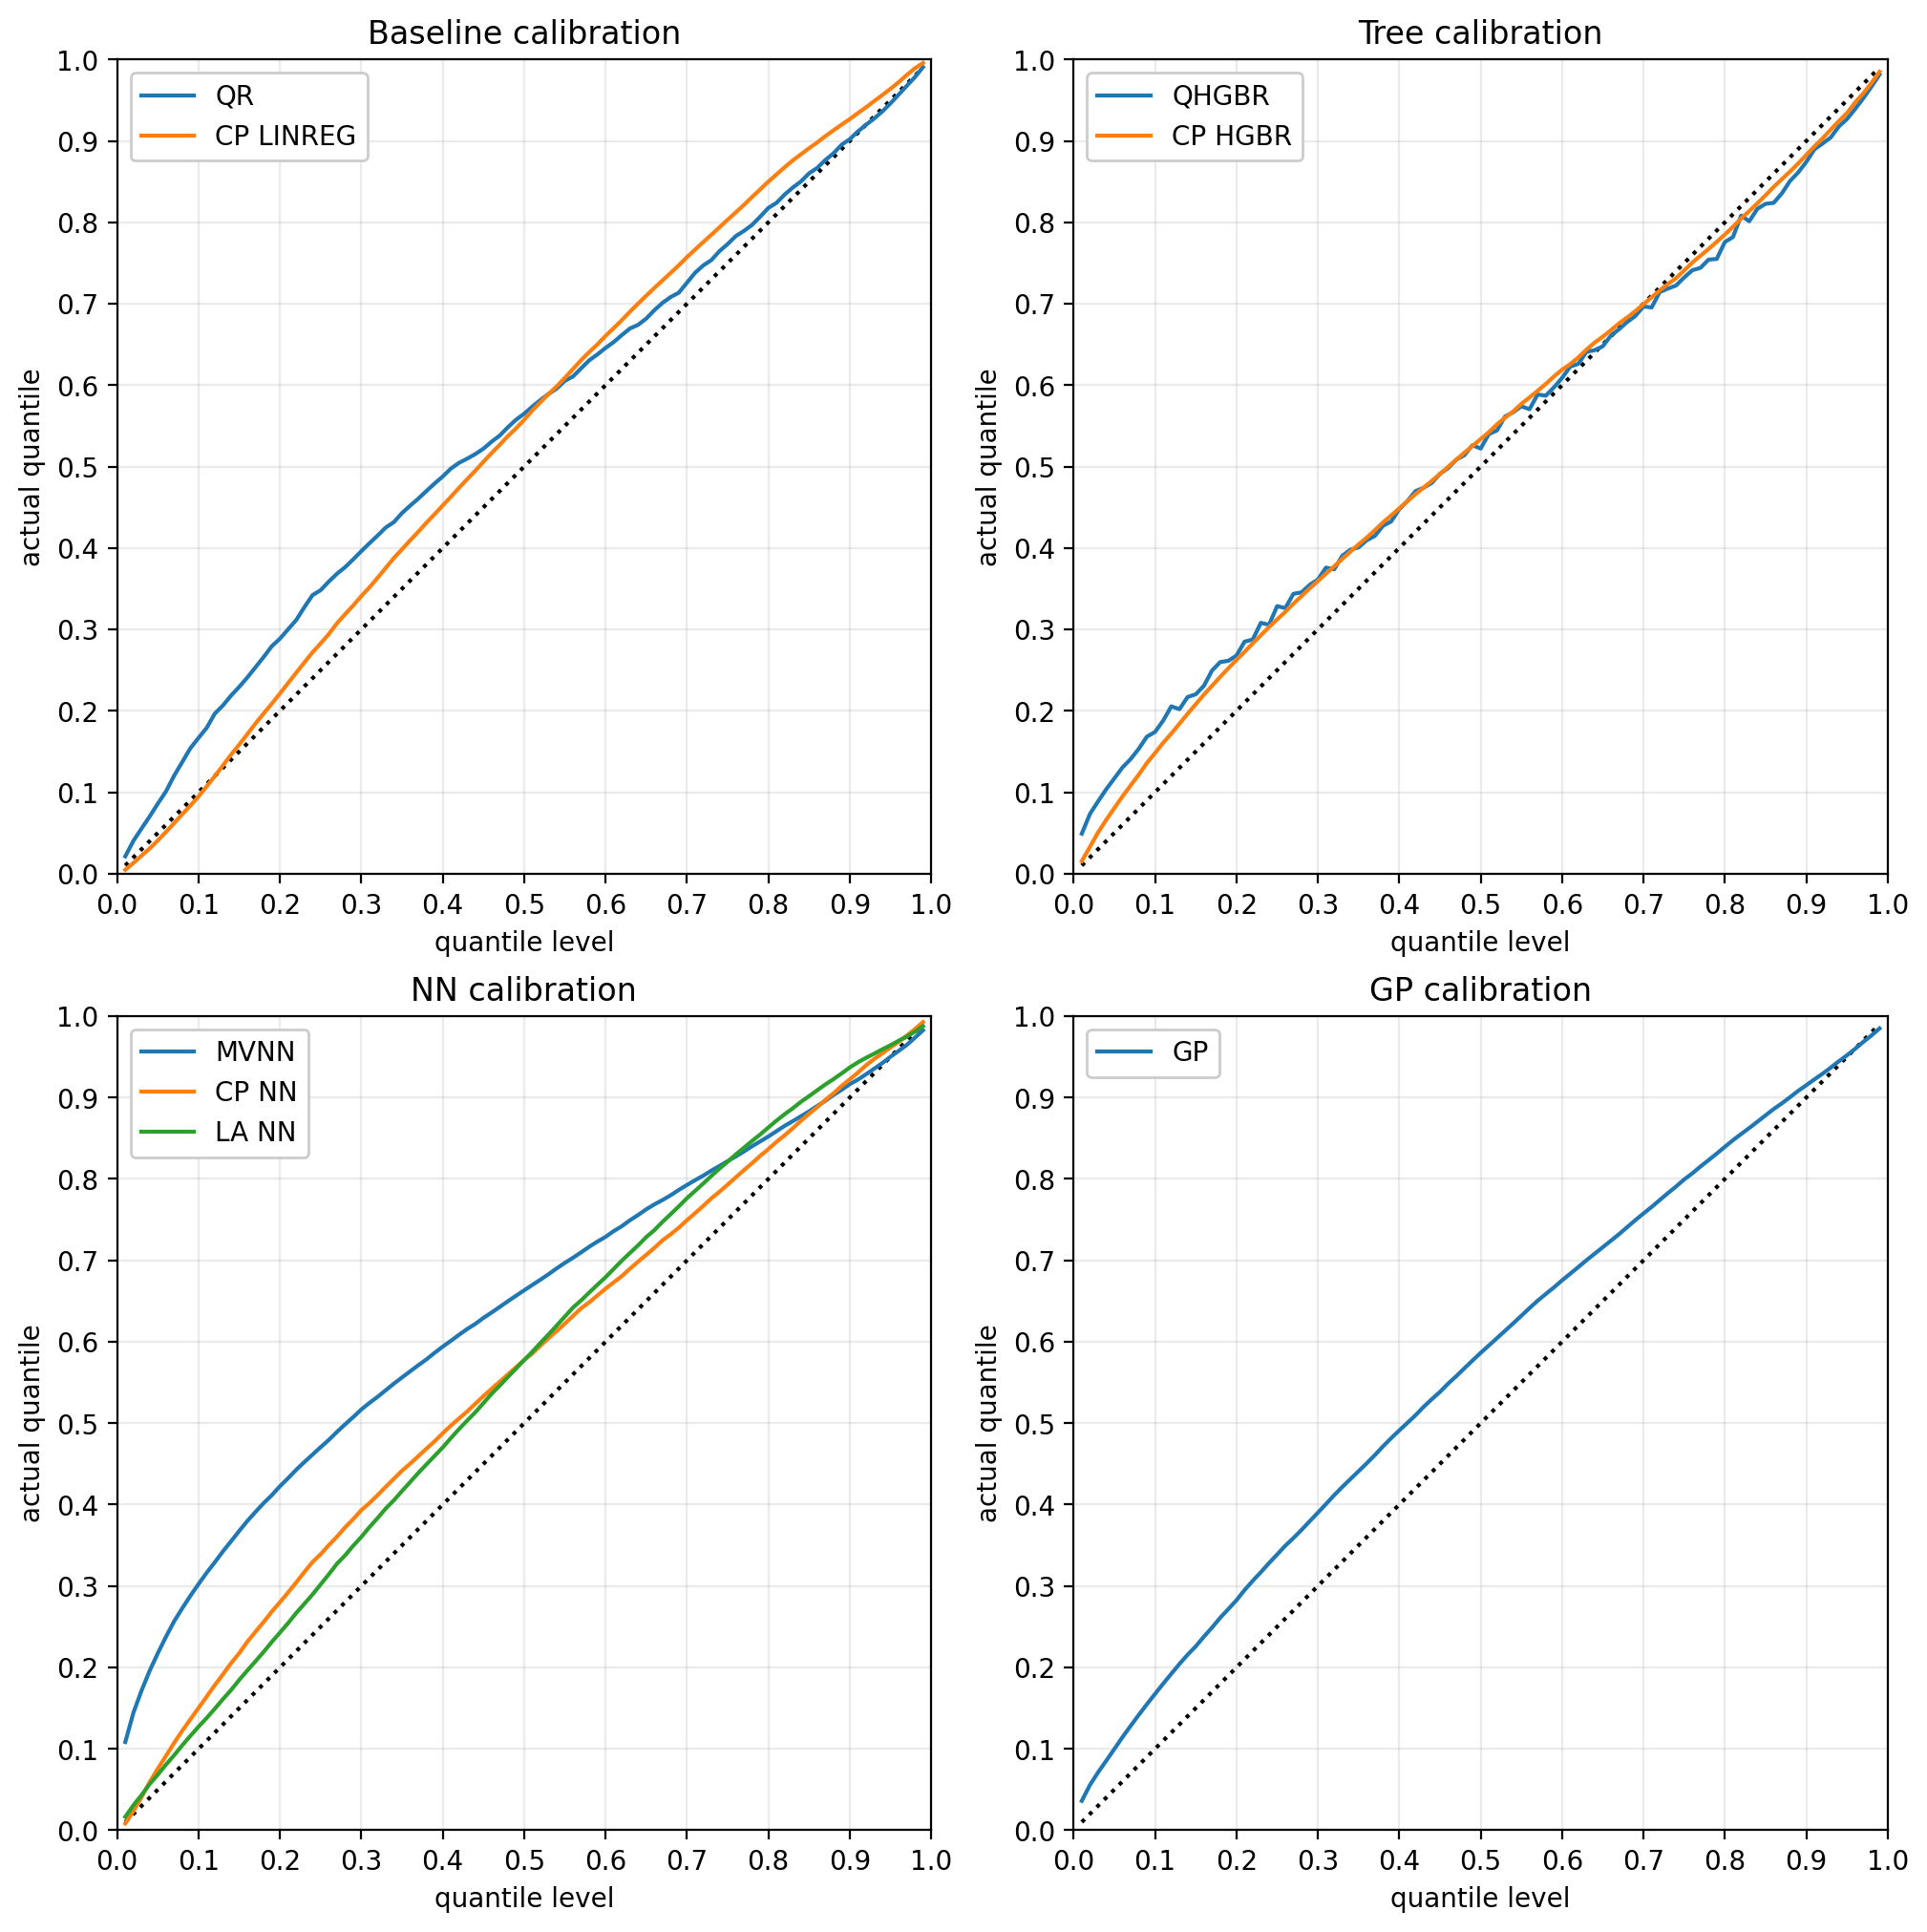

In [6]:
DPI = 200
FILEPATH = 'comparison_storage/plots/calibration_pairs_plot.pdf'

TYPE_TO_METHOD_PAIRS = {
    'Baseline': ['qr', 'cp_linreg'],
    'Tree': ['qhgbr', 'cp_hgbr'],
    'NN': ['mvnn', 'cp_nn', 'la_nn'],
    'GP': ['gp'],
}

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

xlabel = 'quantile level'
ylabel = 'actual quantile'
x_plot = settings.QUANTILES

fig, axs = plt.subplots(2, 2, figsize=(10, 10), layout='constrained', dpi=DPI)
axs = np.ravel(axs)
for ax, (method_type, methods) in zip(axs, TYPE_TO_METHOD_PAIRS.items()):
    print(f'plotting {method_type}')
    ax.set_aspect('equal')
    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.plot(x_plot, x_plot, linestyle='dotted', color='black')
    for method in methods:
        ax.plot(x_plot, method_calibrations[method], label=_clean_label(method))
    ax.set_title(f'{method_type} calibration')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(framealpha=1)
    ax.grid(True, alpha=0.25)

if FILEPATH is not None:
    print('saving')
    plt.savefig(FILEPATH)
print('showing')
plt.show()